# LifeHarmony: Training the Deep Learning Recommender System
This notebook guides you through training, evaluating, and visualizing our LifeHarmony AI recommender system that helps users achieve a balanced life. We'll use the synthetic dataset generated in the previous step and the deep learning model defined in deep_learning_model.py.

## 1. Setup and Imports
Let's start by importing the necessary libraries and our custom model module.

In [5]:
# Standard imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import os
from sklearn.metrics import precision_recall_fscore_support, multilabel_confusion_matrix
import tensorflow as tf
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard

project_path = "/content/drive/MyDrive/DLProject30April"
os.chdir(project_path)

# Import our custom model builder
import sys
if project_path not in sys.path:
    sys.path.append(project_path)

from deep_learning_model import prepare_data, build_harmony_model, get_recommendations

# Set random seeds for reproducibility
import random
np.random.seed(42)
tf.random.set_seed(42)
random.seed(42)

# Check if GPU is available and configure TensorFlow
print("TensorFlow version:", tf.__version__)
print("GPU Available:", tf.config.list_physical_devices('GPU'))

# Configure memory growth for GPUs if available
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)

TensorFlow version: 2.18.0
GPU Available: []


## 2. Data Preparation and Exploration
Let's load the dataset and explore its structure before training.


In [8]:
# Define the dataset path
dataset_path = "/content/drive/MyDrive/DLProject30April/generated_datasets/4_generated_dataset_with_recommendations.xlsx"

# Make sure the file exists
if not os.path.exists(dataset_path):
    print(f"Error: Dataset not found at {dataset_path}")
    # Try to find the file in the current directory
    if os.path.exists("4_generated_dataset_with_recommendations.xlsx"):
        dataset_path = "4_generated_dataset_with_recommendations.xlsx"
        print(f"Found dataset in current directory: {dataset_path}")
    else:
        print("Please make sure the dataset file exists and adjust the path accordingly.")

# Load the dataset for exploration
data = pd.read_excel(dataset_path)

# Display basic information
print(f"Dataset shape: {data.shape}")
print("\nColumns in the dataset:")
print(data.columns.tolist())

# Display sample data
print("\nSample data (first 5 rows):")
data.head()

Dataset shape: (20000, 18)

Columns in the dataset:
['UserID', 'Age', 'Gender', 'Marital Status', 'Occupation', 'Budget', 'Time Allocated (hrs/week)', 'Personality', 'Hobbies', 'Career_Priority', 'Financial_Priority', 'Spiritual_Priority', 'Physical_Priority', 'Intellectual_Priority', 'Family_Priority', 'Social_Priority', 'Fun_Priority', 'Recommendations']

Sample data (first 5 rows):


,UserID,Age,Gender,Marital Status,Occupation,Budget,Time Allocated (hrs/week),Personality,Hobbies,Career_Priority,Financial_Priority,Spiritual_Priority,Physical_Priority,Intellectual_Priority,Family_Priority,Social_Priority,Fun_Priority,Recommendations
0,30700001,39,Female,Single,Freelancer,1375,9,Extrovert,Exercise,Medium,High,Low,Low,Low,High,High,Medium,"['Build financial awareness', 'Track monthly e..."
1,30700002,33,Male,Married,Full-time,5436,4,Introvert,Reading,High,High,Low,High,Low,Medium,Low,Medium,"['Regularly update your resume', 'Allocate 1-3..."
2,30700003,41,Female,Married,Unemployed,611,8,Introvert,Art,Low,High,Low,Low,High,Medium,High,Medium,['Start tracking weekly expenses using an app'...
3,30700004,50,Male,Married,Full-time,4627,3,Introvert,Writing,Low,Medium,High,Medium,Low,Low,High,High,['Allocate time for meditation or reflective p...
4,30700005,32,Female,Married,Unemployed,501,8,Ambivert,Socializing,High,Low,High,High,Low,Medium,Medium,Low,['Allocate 1-3 hours a week into improving you...


Let's analyze the distribution of features and priorities in our dataset.

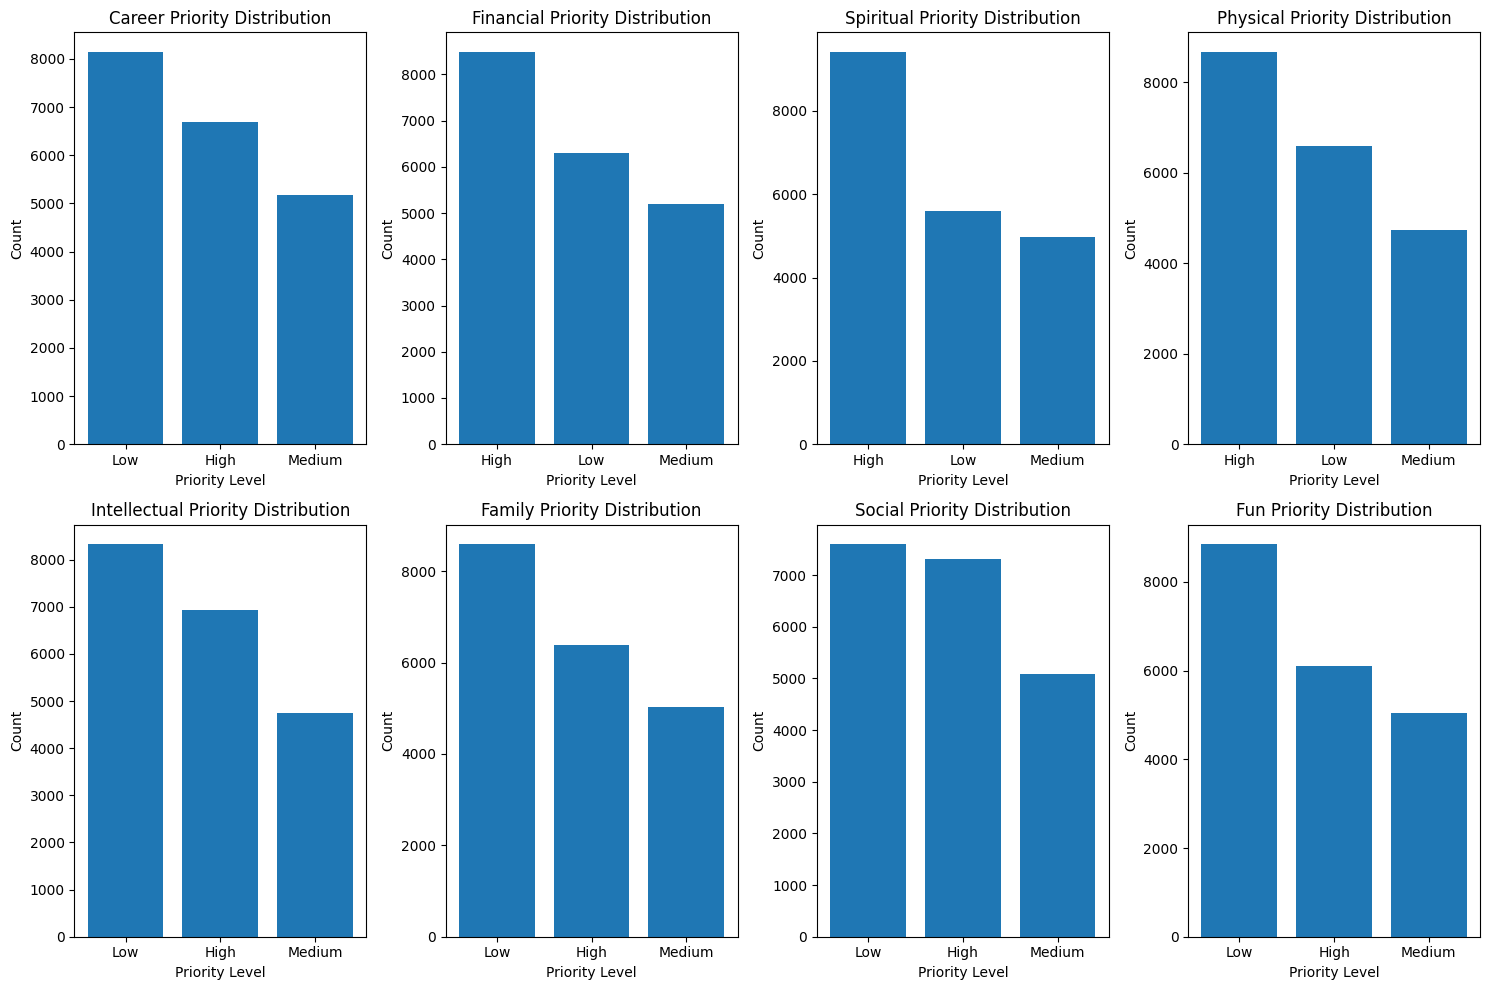

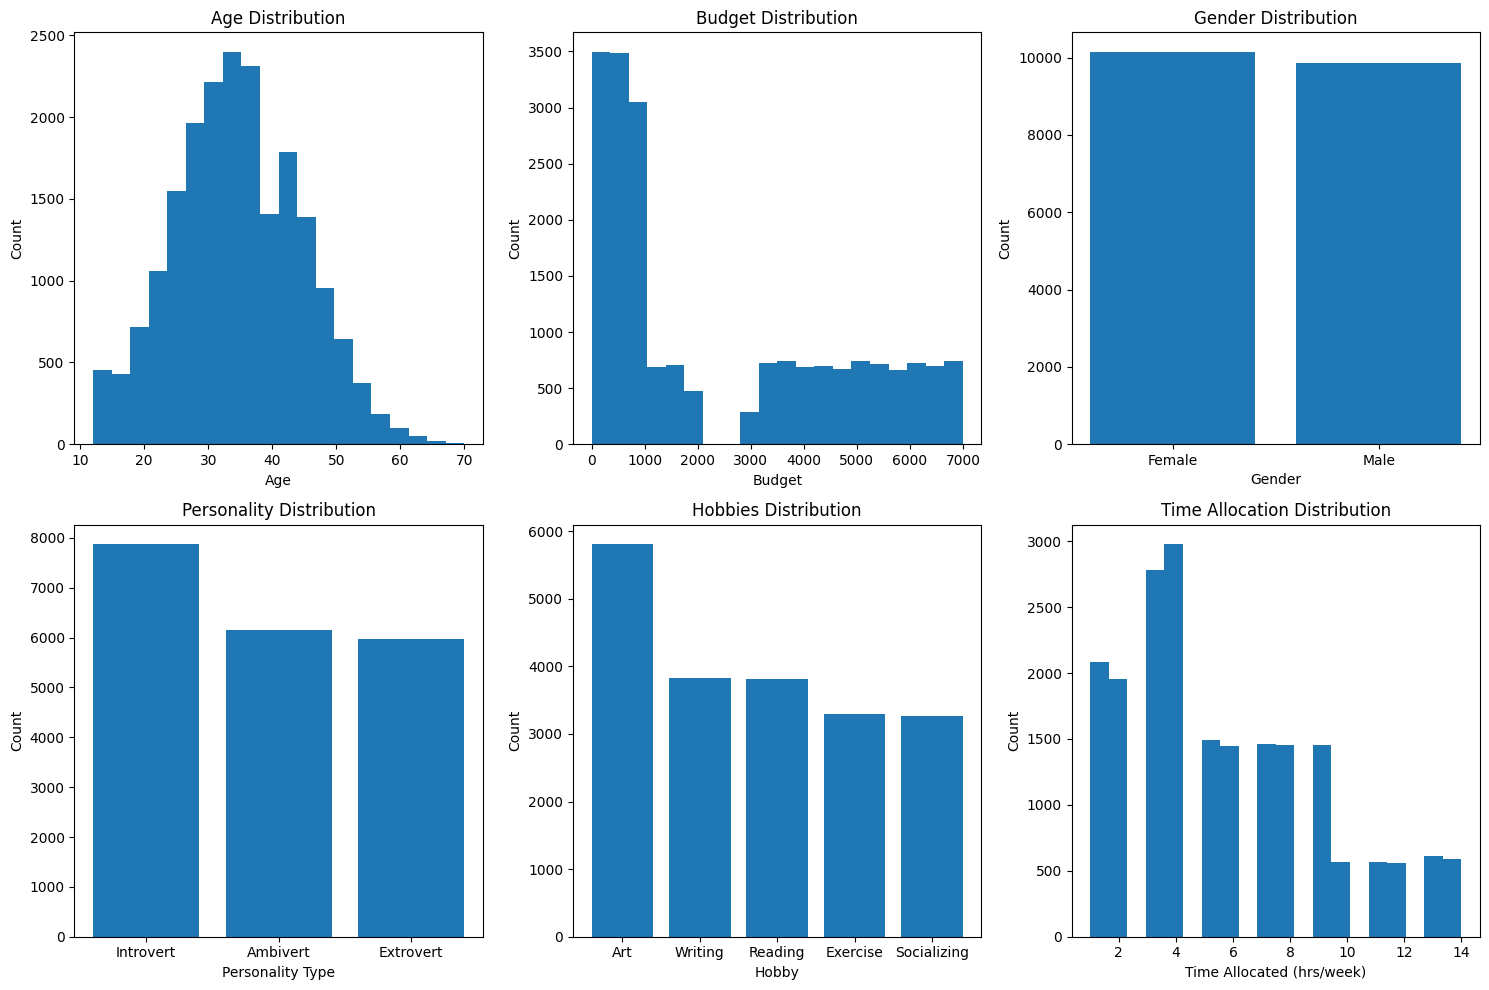

In [9]:
# Count distribution of priorities for each life domain
plt.figure(figsize=(15, 10))

domains = ["Career", "Financial", "Spiritual", "Physical",
           "Intellectual", "Family", "Social", "Fun"]

for i, domain in enumerate(domains):
    plt.subplot(2, 4, i+1)
    priority_counts = data[f"{domain}_Priority"].value_counts()
    plt.bar(priority_counts.index, priority_counts.values)
    plt.title(f"{domain} Priority Distribution")
    plt.xlabel("Priority Level")
    plt.ylabel("Count")

plt.tight_layout()
plt.show()

# Analyze feature distributions
plt.figure(figsize=(15, 10))

# Age distribution
plt.subplot(2, 3, 1)
plt.hist(data["Age"], bins=20)
plt.xlabel("Age")
plt.ylabel("Count")
plt.title("Age Distribution")

# Budget distribution
plt.subplot(2, 3, 2)
plt.hist(data["Budget"], bins=20)
plt.xlabel("Budget")
plt.ylabel("Count")
plt.title("Budget Distribution")

# Gender distribution
plt.subplot(2, 3, 3)
gender_counts = data["Gender"].value_counts()
plt.bar(gender_counts.index, gender_counts.values)
plt.xlabel("Gender")
plt.ylabel("Count")
plt.title("Gender Distribution")

# Personality distribution
plt.subplot(2, 3, 4)
personality_counts = data["Personality"].value_counts()
plt.bar(personality_counts.index, personality_counts.values)
plt.xlabel("Personality Type")
plt.ylabel("Count")
plt.title("Personality Distribution")

# Hobbies distribution
plt.subplot(2, 3, 5)
hobby_counts = data["Hobbies"].value_counts()
plt.bar(hobby_counts.index, hobby_counts.values)
plt.xlabel("Hobby")
plt.ylabel("Count")
plt.title("Hobbies Distribution")

# Time allocation distribution
plt.subplot(2, 3, 6)
plt.hist(data["Time Allocated (hrs/week)"], bins=20)
plt.xlabel("Time Allocated (hrs/week)")
plt.ylabel("Count")
plt.title("Time Allocation Distribution")

plt.tight_layout()
plt.show()

Now, let's analyze the distribution of recommendations.

Total unique recommendations: 40


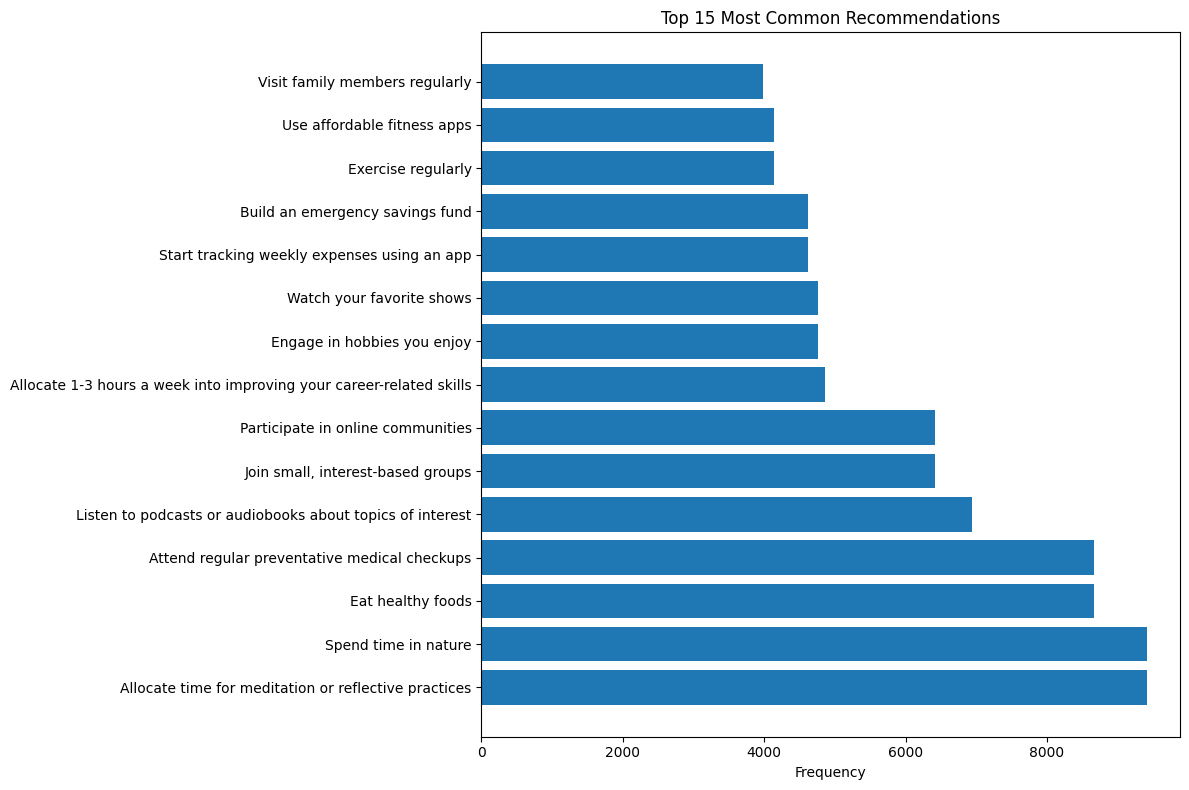

In [10]:
# Extract and analyze unique recommendations
all_recommendations = set()
for _, row in data.iterrows():
    all_recommendations.update(eval(row['Recommendations']))

unique_recommendations = list(all_recommendations)
print(f"Total unique recommendations: {len(unique_recommendations)}")

# Count frequency of each recommendation
recommendation_counts = {}
for _, row in data.iterrows():
    recs = eval(row['Recommendations'])
    for rec in recs:
        if rec in recommendation_counts:
            recommendation_counts[rec] += 1
        else:
            recommendation_counts[rec] = 1

# Plot the most common recommendations
top_recommendations = sorted(recommendation_counts.items(), key=lambda x: x[1], reverse=True)[:15]
plt.figure(figsize=(12, 8))
plt.barh([rec[0] for rec in top_recommendations], [rec[1] for rec in top_recommendations])
plt.xlabel("Frequency")
plt.title("Top 15 Most Common Recommendations")
plt.tight_layout()
plt.show()

## 3. Preparing Data for Training
Now, let's prepare our data for the deep learning model.

Training set shape: X=(16000, 14), y=(16000, 40)
Validation set shape: X=(4000, 14), y=(4000, 40)
Number of unique recommendations: 40

Feature ranges:
Feature 0: Min=-2.00, Max=3.00
Feature 1: Min=0.00, Max=1.00
Feature 2: Min=0.00, Max=4.00
Feature 3: Min=-1.00, Max=2.00
Feature 4: Min=0.00, Max=2.00
Feature 5: Min=0.00, Max=4.00
Feature 6: Min=0.00, Max=2.00
Feature 7: Min=0.00, Max=2.00
Feature 8: Min=0.00, Max=2.00
Feature 9: Min=0.00, Max=2.00
Feature 10: Min=0.00, Max=2.00
Feature 11: Min=0.00, Max=2.00
Feature 12: Min=0.00, Max=2.00
Feature 13: Min=0.00, Max=2.00


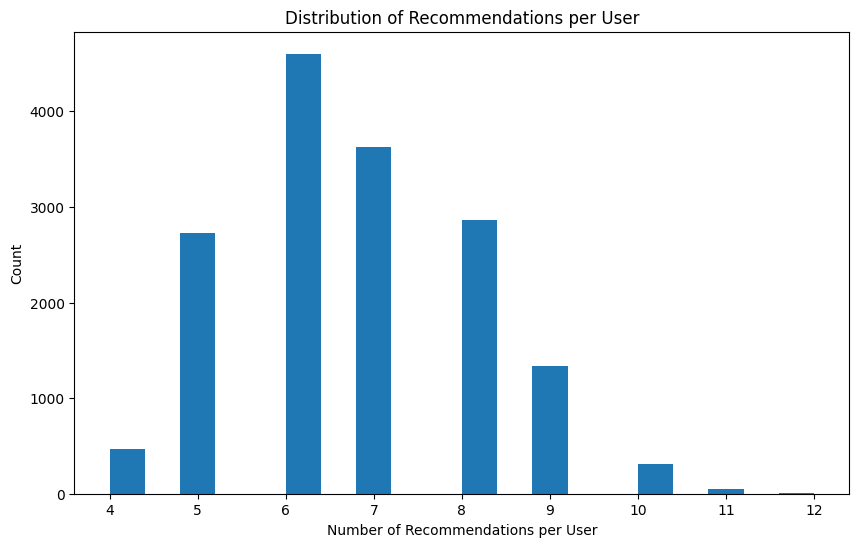

Average recommendations per user: 6.70
Min recommendations per user: 4.0
Max recommendations per user: 12.0


In [11]:
# Use the prepare_data function from our module
X_train, X_val, y_train, y_val, unique_recommendations, scaler = prepare_data(dataset_path)

print(f"Training set shape: X={X_train.shape}, y={y_train.shape}")
print(f"Validation set shape: X={X_val.shape}, y={y_val.shape}")
print(f"Number of unique recommendations: {len(unique_recommendations)}")

# Analyze features in the prepared data
print("\nFeature ranges:")
for i in range(X_train.shape[1]):
    print(f"Feature {i}: Min={X_train[:, i].min():.2f}, Max={X_train[:, i].max():.2f}")

# Analyze class distribution in the output
recommendations_per_sample = y_train.sum(axis=1)
plt.figure(figsize=(10, 6))
plt.hist(recommendations_per_sample, bins=20)
plt.xlabel("Number of Recommendations per User")
plt.ylabel("Count")
plt.title("Distribution of Recommendations per User")
plt.show()

print(f"Average recommendations per user: {recommendations_per_sample.mean():.2f}")
print(f"Min recommendations per user: {recommendations_per_sample.min()}")
print(f"Max recommendations per user: {recommendations_per_sample.max()}")

## 4. Building and Training the Model
Now, let's build and train our deep learning model.

In [12]:
# Define model parameters
input_dim = X_train.shape[1]
output_dim = y_train.shape[1]
hidden_layers = [128, 64, 32]  # Default from the module

# Build the model
model = build_harmony_model(input_dim, output_dim, hidden_layers)

# Display model summary
model.summary()

# Set up callbacks for training
os.makedirs("model_checkpoints", exist_ok=True)
os.makedirs("logs", exist_ok=True)

checkpoint = ModelCheckpoint(
    "model_checkpoints/best_model.h5",
    monitor="val_loss",
    save_best_only=True,
    verbose=1
)

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    patience=10,
    restore_best_weights=True,
    verbose=1
)

tensorboard = TensorBoard(
    log_dir="logs/fit",
    histogram_freq=1,
    write_graph=True
)

# Train the model
history = model.fit(
    X_train, y_train,
    epochs=100,
    batch_size=32,
    validation_data=(X_val, y_val),
    callbacks=[early_stopping, checkpoint, tensorboard],
    verbose=1
)

# Save the final model
model.save("harmony_deep_model.h5")

# Save the recommendation mapping and scaler
with open("harmony_deep_model_recommendations.pkl", "wb") as f:
    pickle.dump(unique_recommendations, f)

with open("harmony_deep_model_scaler.pkl", "wb") as f:
    pickle.dump(scaler, f)

print("Model, recommendations, and scaler saved successfully.")

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 14)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 14)             │            56 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │         1,920 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 32)             │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 40)             │         1,320 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,528 (56.75 KB)

 Trainable params: 14,052 (54.89 KB)

 Non-trainable params: 476 (1.86 KB)

Epoch 1/100
490/500 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.1020 - loss: 0.6168
Epoch 1: val_loss improved from inf to 0.21283, saving model to model_checkpoints/best_model.h5


500/500 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - accuracy: 0.1029 - loss: 0.6134 - val_accuracy: 0.2280 - val_loss: 0.2128
Epoch 2/100
497/500 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.2015 - loss: 0.2493
Epoch 2: val_loss improved from 0.21283 to 0.14387, saving model to model_checkpoints/best_model.h5


500/500 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.2016 - loss: 0.2492 - val_accuracy: 0.2765 - val_loss: 0.1439
Epoch 3/100
488/500 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.2173 - loss: 0.2021
Epoch 3: val_loss improved from 0.14387 to 0.10900, saving model to model_checkpoints/best_model.h5


500/500 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.2173 - loss: 0.2019 - val_accuracy: 0.2965 - val_loss: 0.1090
Epoch 4/100
492/500 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.2169 - loss: 0.1752
Epoch 4: val_loss improved from 0.10900 to 0.09440, saving model to model_checkpoints/best_model.h5


500/500 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.2169 - loss: 0.1751 - val_accuracy: 0.2948 - val_loss: 0.0944
Epoch 5/100
489/500 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.2150 - loss: 0.1585
Epoch 5: val_loss improved from 0.09440 to 0.08556, saving model to model_checkpoints/best_model.h5


500/500 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.2148 - loss: 0.1584 - val_accuracy: 0.2828 - val_loss: 0.0856
Epoch 6/100
491/500 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.1984 - loss: 0.1474
Epoch 6: val_loss improved from 0.08556 to 0.08117, saving model to model_checkpoints/best_model.h5


500/500 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.1985 - loss: 0.1474 - val_accuracy: 0.3085 - val_loss: 0.0812
Epoch 7/100
498/500 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.2072 - loss: 0.1383
Epoch 7: val_loss improved from 0.08117 to 0.07768, saving model to model_checkpoints/best_model.h5


500/500 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.2072 - loss: 0.1383 - val_accuracy: 0.3083 - val_loss: 0.0777
Epoch 8/100
486/500 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.1958 - loss: 0.1318
Epoch 8: val_loss improved from 0.07768 to 0.07480, saving model to model_checkpoints/best_model.h5


500/500 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.1959 - loss: 0.1318 - val_accuracy: 0.3115 - val_loss: 0.0748
Epoch 9/100
487/500 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.1917 - loss: 0.1285
Epoch 9: val_loss improved from 0.07480 to 0.07340, saving model to model_checkpoints/best_model.h5


500/500 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.1917 - loss: 0.1285 - val_accuracy: 0.3313 - val_loss: 0.0734
Epoch 10/100
492/500 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.1929 - loss: 0.1244
Epoch 10: val_loss improved from 0.07340 to 0.07200, saving model to model_checkpoints/best_model.h5


500/500 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.1929 - loss: 0.1244 - val_accuracy: 0.2447 - val_loss: 0.0720
Epoch 11/100
486/500 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.1744 - loss: 0.1202
Epoch 11: val_loss improved from 0.07200 to 0.07063, saving model to model_checkpoints/best_model.h5


500/500 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.1745 - loss: 0.1202 - val_accuracy: 0.2430 - val_loss: 0.0706
Epoch 12/100
494/500 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.1774 - loss: 0.1187
Epoch 12: val_loss improved from 0.07063 to 0.07020, saving model to model_checkpoints/best_model.h5


500/500 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.1774 - loss: 0.1187 - val_accuracy: 0.2275 - val_loss: 0.0702
Epoch 13/100
496/500 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.1762 - loss: 0.1172
Epoch 13: val_loss improved from 0.07020 to 0.06883, saving model to model_checkpoints/best_model.h5


500/500 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.1762 - loss: 0.1172 - val_accuracy: 0.1995 - val_loss: 0.0688
Epoch 14/100
492/500 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.1767 - loss: 0.1144
Epoch 14: val_loss improved from 0.06883 to 0.06818, saving model to model_checkpoints/best_model.h5


500/500 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.1767 - loss: 0.1144 - val_accuracy: 0.2268 - val_loss: 0.0682
Epoch 15/100
499/500 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.1794 - loss: 0.1128
Epoch 15: val_loss improved from 0.06818 to 0.06735, saving model to model_checkpoints/best_model.h5


500/500 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.1795 - loss: 0.1128 - val_accuracy: 0.2815 - val_loss: 0.0673
Epoch 16/100
485/500 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.1914 - loss: 0.1110
Epoch 16: val_loss improved from 0.06735 to 0.06701, saving model to model_checkpoints/best_model.h5


500/500 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.1916 - loss: 0.1110 - val_accuracy: 0.3013 - val_loss: 0.0670
Epoch 17/100
495/500 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.2046 - loss: 0.1107
Epoch 17: val_loss improved from 0.06701 to 0.06603, saving model to model_checkpoints/best_model.h5


500/500 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.2046 - loss: 0.1107 - val_accuracy: 0.2288 - val_loss: 0.0660
Epoch 18/100
491/500 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.2052 - loss: 0.1100
Epoch 18: val_loss improved from 0.06603 to 0.06545, saving model to model_checkpoints/best_model.h5


500/500 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.2051 - loss: 0.1100 - val_accuracy: 0.2848 - val_loss: 0.0655
Epoch 19/100
489/500 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.2121 - loss: 0.1082
Epoch 19: val_loss improved from 0.06545 to 0.06467, saving model to model_checkpoints/best_model.h5


500/500 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.2121 - loss: 0.1082 - val_accuracy: 0.3372 - val_loss: 0.0647
Epoch 20/100
488/500 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.2097 - loss: 0.1069
Epoch 20: val_loss improved from 0.06467 to 0.06407, saving model to model_checkpoints/best_model.h5


500/500 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.2099 - loss: 0.1069 - val_accuracy: 0.3195 - val_loss: 0.0641
Epoch 21/100
489/500 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.2177 - loss: 0.1058
Epoch 21: val_loss improved from 0.06407 to 0.06344, saving model to model_checkpoints/best_model.h5


500/500 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.2178 - loss: 0.1058 - val_accuracy: 0.3232 - val_loss: 0.0634
Epoch 22/100
491/500 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.2199 - loss: 0.1055
Epoch 22: val_loss improved from 0.06344 to 0.06273, saving model to model_checkpoints/best_model.h5


500/500 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.2200 - loss: 0.1055 - val_accuracy: 0.3425 - val_loss: 0.0627
Epoch 23/100
491/500 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.2231 - loss: 0.1045
Epoch 23: val_loss improved from 0.06273 to 0.06174, saving model to model_checkpoints/best_model.h5


500/500 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.2231 - loss: 0.1045 - val_accuracy: 0.3147 - val_loss: 0.0617
Epoch 24/100
493/500 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.2277 - loss: 0.1050
Epoch 24: val_loss improved from 0.06174 to 0.06027, saving model to model_checkpoints/best_model.h5


500/500 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.2277 - loss: 0.1050 - val_accuracy: 0.3232 - val_loss: 0.0603
Epoch 25/100
498/500 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.2320 - loss: 0.1036
Epoch 25: val_loss improved from 0.06027 to 0.05964, saving model to model_checkpoints/best_model.h5


500/500 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.2320 - loss: 0.1036 - val_accuracy: 0.3492 - val_loss: 0.0596
Epoch 26/100
498/500 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.2337 - loss: 0.1011
Epoch 26: val_loss improved from 0.05964 to 0.05861, saving model to model_checkpoints/best_model.h5


500/500 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.2337 - loss: 0.1011 - val_accuracy: 0.3232 - val_loss: 0.0586
Epoch 27/100
493/500 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.2321 - loss: 0.1006
Epoch 27: val_loss improved from 0.05861 to 0.05792, saving model to model_checkpoints/best_model.h5


500/500 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.2322 - loss: 0.1006 - val_accuracy: 0.3760 - val_loss: 0.0579
Epoch 28/100
497/500 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.2370 - loss: 0.1016
Epoch 28: val_loss improved from 0.05792 to 0.05640, saving model to model_checkpoints/best_model.h5


500/500 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.2370 - loss: 0.1016 - val_accuracy: 0.3817 - val_loss: 0.0564
Epoch 29/100
499/500 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.2451 - loss: 0.0998
Epoch 29: val_loss improved from 0.05640 to 0.05593, saving model to model_checkpoints/best_model.h5


500/500 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.2451 - loss: 0.0998 - val_accuracy: 0.3730 - val_loss: 0.0559
Epoch 30/100
488/500 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.2372 - loss: 0.1004
Epoch 30: val_loss improved from 0.05593 to 0.05562, saving model to model_checkpoints/best_model.h5


500/500 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.2372 - loss: 0.1004 - val_accuracy: 0.3492 - val_loss: 0.0556
Epoch 31/100
492/500 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.2297 - loss: 0.0993
Epoch 31: val_loss improved from 0.05562 to 0.05442, saving model to model_checkpoints/best_model.h5


500/500 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.2297 - loss: 0.0993 - val_accuracy: 0.3390 - val_loss: 0.0544
Epoch 32/100
492/500 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.2345 - loss: 0.0995
Epoch 32: val_loss improved from 0.05442 to 0.05315, saving model to model_checkpoints/best_model.h5


500/500 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.2344 - loss: 0.0995 - val_accuracy: 0.3490 - val_loss: 0.0532
Epoch 33/100
500/500 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.2268 - loss: 0.0968
Epoch 33: val_loss improved from 0.05315 to 0.05214, saving model to model_checkpoints/best_model.h5


500/500 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.2267 - loss: 0.0968 - val_accuracy: 0.3083 - val_loss: 0.0521
Epoch 34/100
500/500 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.2293 - loss: 0.0965
Epoch 34: val_loss improved from 0.05214 to 0.05190, saving model to model_checkpoints/best_model.h5


500/500 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.2293 - loss: 0.0965 - val_accuracy: 0.3002 - val_loss: 0.0519
Epoch 35/100
495/500 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.2362 - loss: 0.0961
Epoch 35: val_loss improved from 0.05190 to 0.05047, saving model to model_checkpoints/best_model.h5


500/500 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.2362 - loss: 0.0961 - val_accuracy: 0.3428 - val_loss: 0.0505
Epoch 36/100
496/500 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.2356 - loss: 0.0950
Epoch 36: val_loss improved from 0.05047 to 0.04925, saving model to model_checkpoints/best_model.h5


500/500 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.2356 - loss: 0.0950 - val_accuracy: 0.2988 - val_loss: 0.0493
Epoch 37/100
497/500 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.2248 - loss: 0.0946
Epoch 37: val_loss improved from 0.04925 to 0.04763, saving model to model_checkpoints/best_model.h5


500/500 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.2248 - loss: 0.0946 - val_accuracy: 0.3173 - val_loss: 0.0476
Epoch 38/100
490/500 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.2172 - loss: 0.0935
Epoch 38: val_loss improved from 0.04763 to 0.04662, saving model to model_checkpoints/best_model.h5


500/500 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.2172 - loss: 0.0935 - val_accuracy: 0.2995 - val_loss: 0.0466
Epoch 39/100
500/500 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.2218 - loss: 0.0920
Epoch 39: val_loss improved from 0.04662 to 0.04524, saving model to model_checkpoints/best_model.h5


500/500 ━━━━━━━━━━━━━━━━━━━━ 6s 11ms/step - accuracy: 0.2218 - loss: 0.0920 - val_accuracy: 0.3200 - val_loss: 0.0452
Epoch 40/100
498/500 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.2204 - loss: 0.0929
Epoch 40: val_loss did not improve from 0.04524
500/500 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.2204 - loss: 0.0929 - val_accuracy: 0.3047 - val_loss: 0.0454
Epoch 41/100
496/500 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.2297 - loss: 0.0920
Epoch 41: val_loss improved from 0.04524 to 0.04372, saving model to model_checkpoints/best_model.h5


500/500 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.2297 - loss: 0.0920 - val_accuracy: 0.3113 - val_loss: 0.0437
Epoch 42/100
495/500 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.2218 - loss: 0.0911
Epoch 42: val_loss improved from 0.04372 to 0.04328, saving model to model_checkpoints/best_model.h5


500/500 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.2218 - loss: 0.0911 - val_accuracy: 0.2772 - val_loss: 0.0433
Epoch 43/100
498/500 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.2219 - loss: 0.0906
Epoch 43: val_loss improved from 0.04328 to 0.04229, saving model to model_checkpoints/best_model.h5


500/500 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.2219 - loss: 0.0906 - val_accuracy: 0.2940 - val_loss: 0.0423
Epoch 44/100
496/500 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.2262 - loss: 0.0899
Epoch 44: val_loss improved from 0.04229 to 0.04122, saving model to model_checkpoints/best_model.h5


500/500 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.2262 - loss: 0.0899 - val_accuracy: 0.2760 - val_loss: 0.0412
Epoch 45/100
497/500 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.2154 - loss: 0.0890
Epoch 45: val_loss improved from 0.04122 to 0.04098, saving model to model_checkpoints/best_model.h5


500/500 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.2154 - loss: 0.0890 - val_accuracy: 0.2765 - val_loss: 0.0410
Epoch 46/100
490/500 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.2253 - loss: 0.0883
Epoch 46: val_loss improved from 0.04098 to 0.04034, saving model to model_checkpoints/best_model.h5


500/500 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.2252 - loss: 0.0883 - val_accuracy: 0.3097 - val_loss: 0.0403
Epoch 47/100
497/500 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.2159 - loss: 0.0904
Epoch 47: val_loss improved from 0.04034 to 0.03988, saving model to model_checkpoints/best_model.h5


500/500 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.2159 - loss: 0.0904 - val_accuracy: 0.2072 - val_loss: 0.0399
Epoch 48/100
496/500 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.2089 - loss: 0.0881
Epoch 48: val_loss improved from 0.03988 to 0.03900, saving model to model_checkpoints/best_model.h5


500/500 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.2089 - loss: 0.0881 - val_accuracy: 0.2425 - val_loss: 0.0390
Epoch 49/100
494/500 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.2151 - loss: 0.0880
Epoch 49: val_loss improved from 0.03900 to 0.03846, saving model to model_checkpoints/best_model.h5


500/500 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.2151 - loss: 0.0880 - val_accuracy: 0.2185 - val_loss: 0.0385
Epoch 50/100
487/500 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.2164 - loss: 0.0884
Epoch 50: val_loss improved from 0.03846 to 0.03804, saving model to model_checkpoints/best_model.h5


500/500 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.2164 - loss: 0.0883 - val_accuracy: 0.2373 - val_loss: 0.0380
Epoch 51/100
494/500 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.2176 - loss: 0.0880
Epoch 51: val_loss improved from 0.03804 to 0.03791, saving model to model_checkpoints/best_model.h5


500/500 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.2176 - loss: 0.0880 - val_accuracy: 0.2153 - val_loss: 0.0379
Epoch 52/100
496/500 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.2106 - loss: 0.0874
Epoch 52: val_loss improved from 0.03791 to 0.03735, saving model to model_checkpoints/best_model.h5


500/500 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.2106 - loss: 0.0874 - val_accuracy: 0.1933 - val_loss: 0.0373
Epoch 53/100
492/500 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.2002 - loss: 0.0874
Epoch 53: val_loss did not improve from 0.03735
500/500 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.2002 - loss: 0.0874 - val_accuracy: 0.2110 - val_loss: 0.0374
Epoch 54/100
499/500 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.2016 - loss: 0.0865
Epoch 54: val_loss improved from 0.03735 to 0.03698, saving model to model_checkpoints/best_model.h5


500/500 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.2016 - loss: 0.0865 - val_accuracy: 0.1890 - val_loss: 0.0370
Epoch 55/100
490/500 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.2058 - loss: 0.0858
Epoch 55: val_loss improved from 0.03698 to 0.03641, saving model to model_checkpoints/best_model.h5


500/500 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.2057 - loss: 0.0857 - val_accuracy: 0.2247 - val_loss: 0.0364
Epoch 56/100
498/500 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.2048 - loss: 0.0858
Epoch 56: val_loss improved from 0.03641 to 0.03628, saving model to model_checkpoints/best_model.h5


500/500 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.2048 - loss: 0.0858 - val_accuracy: 0.1857 - val_loss: 0.0363
Epoch 57/100
493/500 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.2013 - loss: 0.0854
Epoch 57: val_loss improved from 0.03628 to 0.03598, saving model to model_checkpoints/best_model.h5


500/500 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.2012 - loss: 0.0854 - val_accuracy: 0.1455 - val_loss: 0.0360
Epoch 58/100
493/500 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.1885 - loss: 0.0851
Epoch 58: val_loss did not improve from 0.03598
500/500 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.1885 - loss: 0.0851 - val_accuracy: 0.1610 - val_loss: 0.0366
Epoch 59/100
487/500 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.1829 - loss: 0.0850
Epoch 59: val_loss improved from 0.03598 to 0.03574, saving model to model_checkpoints/best_model.h5


500/500 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.1828 - loss: 0.0850 - val_accuracy: 0.1203 - val_loss: 0.0357
Epoch 60/100
490/500 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.1852 - loss: 0.0844
Epoch 60: val_loss did not improve from 0.03574
500/500 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.1852 - loss: 0.0844 - val_accuracy: 0.1107 - val_loss: 0.0360
Epoch 61/100
496/500 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.1836 - loss: 0.0838
Epoch 61: val_loss improved from 0.03574 to 0.03542, saving model to model_checkpoints/best_model.h5


500/500 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.1835 - loss: 0.0838 - val_accuracy: 0.1002 - val_loss: 0.0354
Epoch 62/100
486/500 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.1807 - loss: 0.0840
Epoch 62: val_loss did not improve from 0.03542
500/500 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.1806 - loss: 0.0840 - val_accuracy: 0.1182 - val_loss: 0.0357
Epoch 63/100
487/500 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.1757 - loss: 0.0852
Epoch 63: val_loss improved from 0.03542 to 0.03508, saving model to model_checkpoints/best_model.h5


500/500 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.1756 - loss: 0.0852 - val_accuracy: 0.0943 - val_loss: 0.0351
Epoch 64/100
500/500 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.1587 - loss: 0.0843
Epoch 64: val_loss improved from 0.03508 to 0.03495, saving model to model_checkpoints/best_model.h5


500/500 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.1587 - loss: 0.0843 - val_accuracy: 0.0895 - val_loss: 0.0349
Epoch 65/100
494/500 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.1657 - loss: 0.0836
Epoch 65: val_loss did not improve from 0.03495
500/500 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.1656 - loss: 0.0836 - val_accuracy: 0.0707 - val_loss: 0.0351
Epoch 66/100
492/500 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.1488 - loss: 0.0834
Epoch 66: val_loss did not improve from 0.03495
500/500 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.1488 - loss: 0.0834 - val_accuracy: 0.0585 - val_loss: 0.0354
Epoch 67/100
488/500 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.1458 - loss: 0.0822
Epoch 67: val_loss improved from 0.03495 to 0.03440, saving model to model_checkpoints/best_model.h5


500/500 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.1458 - loss: 0.0822 - val_accuracy: 0.0698 - val_loss: 0.0344
Epoch 68/100
491/500 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.1444 - loss: 0.0833
Epoch 68: val_loss did not improve from 0.03440
500/500 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.1444 - loss: 0.0833 - val_accuracy: 0.0655 - val_loss: 0.0346
Epoch 69/100
494/500 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.1408 - loss: 0.0828
Epoch 69: val_loss improved from 0.03440 to 0.03428, saving model to model_checkpoints/best_model.h5


500/500 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.1408 - loss: 0.0828 - val_accuracy: 0.0440 - val_loss: 0.0343
Epoch 70/100
496/500 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.1388 - loss: 0.0830
Epoch 70: val_loss improved from 0.03428 to 0.03425, saving model to model_checkpoints/best_model.h5


500/500 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.1388 - loss: 0.0830 - val_accuracy: 0.0487 - val_loss: 0.0342
Epoch 71/100
500/500 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.1385 - loss: 0.0832
Epoch 71: val_loss improved from 0.03425 to 0.03394, saving model to model_checkpoints/best_model.h5


500/500 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.1385 - loss: 0.0832 - val_accuracy: 0.0405 - val_loss: 0.0339
Epoch 72/100
490/500 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.1241 - loss: 0.0837
Epoch 72: val_loss did not improve from 0.03394
500/500 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.1240 - loss: 0.0837 - val_accuracy: 0.0425 - val_loss: 0.0344
Epoch 73/100
499/500 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.1234 - loss: 0.0821
Epoch 73: val_loss did not improve from 0.03394
500/500 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.1234 - loss: 0.0821 - val_accuracy: 0.0437 - val_loss: 0.0340
Epoch 74/100
496/500 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.1307 - loss: 0.0821
Epoch 74: val_loss improved from 0.03394 to 0.03380, saving model to model_checkpoints/best_model.h5


500/500 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.1306 - loss: 0.0820 - val_accuracy: 0.0310 - val_loss: 0.0338
Epoch 75/100
492/500 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.1140 - loss: 0.0815
Epoch 75: val_loss did not improve from 0.03380
500/500 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.1140 - loss: 0.0814 - val_accuracy: 0.0312 - val_loss: 0.0340
Epoch 76/100
489/500 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.1116 - loss: 0.0823
Epoch 76: val_loss did not improve from 0.03380
500/500 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.1117 - loss: 0.0823 - val_accuracy: 0.0302 - val_loss: 0.0343
Epoch 77/100
489/500 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.1104 - loss: 0.0815
Epoch 77: val_loss improved from 0.03380 to 0.03380, saving model to model_checkpoints/best_model.h5


500/500 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.1102 - loss: 0.0815 - val_accuracy: 0.0235 - val_loss: 0.0338
Epoch 78/100
484/500 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.1044 - loss: 0.0817
Epoch 78: val_loss improved from 0.03380 to 0.03339, saving model to model_checkpoints/best_model.h5


500/500 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.1044 - loss: 0.0817 - val_accuracy: 0.0282 - val_loss: 0.0334
Epoch 79/100
498/500 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.1009 - loss: 0.0806
Epoch 79: val_loss did not improve from 0.03339
500/500 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.1009 - loss: 0.0806 - val_accuracy: 0.0225 - val_loss: 0.0337
Epoch 80/100
499/500 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.1119 - loss: 0.0816
Epoch 80: val_loss did not improve from 0.03339
500/500 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.1119 - loss: 0.0816 - val_accuracy: 0.0245 - val_loss: 0.0336
Epoch 81/100
490/500 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.1023 - loss: 0.0816
Epoch 81: val_loss did not improve from 0.03339
500/500 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.1023 - loss: 0.0816 - val_accuracy: 0.0227 - val_loss: 0.0337
Epoch 82/100
488/500 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.0969 - loss: 0.0813
Epoch 82: val_loss did not improve f

500/500 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.1073 - loss: 0.0814 - val_accuracy: 0.0268 - val_loss: 0.0331
Epoch 84/100
491/500 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.0977 - loss: 0.0807
Epoch 84: val_loss did not improve from 0.03311
500/500 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.0977 - loss: 0.0807 - val_accuracy: 0.0192 - val_loss: 0.0335
Epoch 85/100
495/500 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.0954 - loss: 0.0807
Epoch 85: val_loss improved from 0.03311 to 0.03280, saving model to model_checkpoints/best_model.h5


500/500 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.0953 - loss: 0.0807 - val_accuracy: 0.0223 - val_loss: 0.0328
Epoch 86/100
495/500 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.0951 - loss: 0.0815
Epoch 86: val_loss improved from 0.03280 to 0.03274, saving model to model_checkpoints/best_model.h5


500/500 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.0951 - loss: 0.0815 - val_accuracy: 0.0215 - val_loss: 0.0327
Epoch 87/100
497/500 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.0966 - loss: 0.0805
Epoch 87: val_loss improved from 0.03274 to 0.03267, saving model to model_checkpoints/best_model.h5


500/500 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.0965 - loss: 0.0805 - val_accuracy: 0.0170 - val_loss: 0.0327
Epoch 88/100
492/500 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.0915 - loss: 0.0804
Epoch 88: val_loss improved from 0.03267 to 0.03234, saving model to model_checkpoints/best_model.h5


500/500 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.0914 - loss: 0.0804 - val_accuracy: 0.0165 - val_loss: 0.0323
Epoch 89/100
489/500 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.0904 - loss: 0.0805
Epoch 89: val_loss did not improve from 0.03234
500/500 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.0904 - loss: 0.0804 - val_accuracy: 0.0103 - val_loss: 0.0327
Epoch 90/100
485/500 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.0875 - loss: 0.0806
Epoch 90: val_loss did not improve from 0.03234
500/500 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.0875 - loss: 0.0806 - val_accuracy: 0.0113 - val_loss: 0.0324
Epoch 91/100
497/500 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.0935 - loss: 0.0804
Epoch 91: val_loss did not improve from 0.03234
500/500 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.0935 - loss: 0.0804 - val_accuracy: 0.0120 - val_loss: 0.0324
Epoch 92/100
497/500 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.0856 - loss: 0.0812
Epoch 92: val_loss improved from 0.0

500/500 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.0856 - loss: 0.0812 - val_accuracy: 0.0098 - val_loss: 0.0322
Epoch 93/100
498/500 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.0775 - loss: 0.0793
Epoch 93: val_loss improved from 0.03220 to 0.03197, saving model to model_checkpoints/best_model.h5


500/500 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.0775 - loss: 0.0793 - val_accuracy: 0.0127 - val_loss: 0.0320
Epoch 94/100
494/500 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.0806 - loss: 0.0797
Epoch 94: val_loss did not improve from 0.03197
500/500 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.0806 - loss: 0.0797 - val_accuracy: 0.0088 - val_loss: 0.0324
Epoch 95/100
488/500 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.0757 - loss: 0.0810
Epoch 95: val_loss did not improve from 0.03197
500/500 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.0758 - loss: 0.0809 - val_accuracy: 0.0143 - val_loss: 0.0325
Epoch 96/100
487/500 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.0765 - loss: 0.0790
Epoch 96: val_loss improved from 0.03197 to 0.03118, saving model to model_checkpoints/best_model.h5


500/500 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.0766 - loss: 0.0789 - val_accuracy: 0.0125 - val_loss: 0.0312
Epoch 97/100
497/500 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.0765 - loss: 0.0791
Epoch 97: val_loss did not improve from 0.03118
500/500 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.0764 - loss: 0.0791 - val_accuracy: 0.0098 - val_loss: 0.0324
Epoch 98/100
494/500 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.0810 - loss: 0.0804
Epoch 98: val_loss did not improve from 0.03118
500/500 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.0810 - loss: 0.0804 - val_accuracy: 0.0117 - val_loss: 0.0319
Epoch 99/100
489/500 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.0784 - loss: 0.0805
Epoch 99: val_loss did not improve from 0.03118
500/500 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.0784 - loss: 0.0805 - val_accuracy: 0.0105 - val_loss: 0.0323
Epoch 100/100
495/500 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.0754 - loss: 0.0796
Epoch 100: val_loss did not improve

Model, recommendations, and scaler saved successfully.


## 5. Evaluating Model Performance
Let's evaluate how well our model performs.

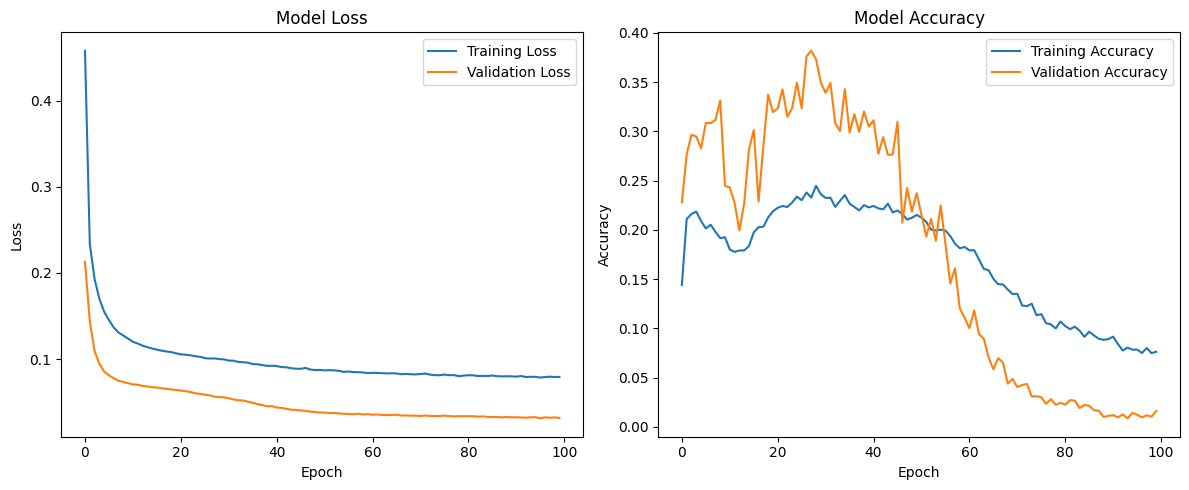

125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Precision: 0.9677
Recall: 0.9669
F1 Score: 0.9659

Top 5 Best Predicted Recommendations:
- Allocate time for meditation or reflective practices: F1=1.0000, Precision=1.0000, Recall=1.0000
- Join social recreational activities: F1=1.0000, Precision=1.0000, Recall=1.0000
- Start an online course: F1=1.0000, Precision=1.0000, Recall=1.0000
- Host weekly family game nights: F1=1.0000, Precision=1.0000, Recall=1.0000
- Join group art classes: F1=1.0000, Precision=1.0000, Recall=1.0000

Bottom 5 Worst Predicted Recommendations:
- Consider low-impact fitness plans like walking or swimming: F1=0.4606, Precision=0.7037, Recall=0.3423
- Join writing circles: F1=0.2588, Precision=1.0000, Recall=0.1486
- Participate in writing competitions: F1=0.2588, Precision=1.0000, Recall=0.1486
- Set personal reading goals: F1=0.0000, Precision=0.0000, Recall=0.0000
- Join book clubs: F1=0.0000, Precision=0.0000, Recall=0.0000


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [13]:
# Plot training history
plt.figure(figsize=(12, 5))

# Plot training & validation loss
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plot training & validation accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

# Calculate predictions on validation set
y_pred_proba = model.predict(X_val)
y_pred = (y_pred_proba > 0.3).astype(int)  # Using 0.3 as threshold

# Calculate precision, recall, and F1 score
precision, recall, f1, _ = precision_recall_fscore_support(
    y_val, y_pred, average='samples'
)

print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

# Calculate metrics for each recommendation class
precision_per_class, recall_per_class, f1_per_class, _ = precision_recall_fscore_support(
    y_val, y_pred, average=None
)

# Top and bottom performing recommendations
recommendations_metrics = list(zip(unique_recommendations, precision_per_class, recall_per_class, f1_per_class))
recommendations_metrics.sort(key=lambda x: x[3], reverse=True)  # Sort by F1 score

print("\nTop 5 Best Predicted Recommendations:")
for rec, prec, rec_val, f1 in recommendations_metrics[:5]:
    print(f"- {rec}: F1={f1:.4f}, Precision={prec:.4f}, Recall={rec_val:.4f}")

print("\nBottom 5 Worst Predicted Recommendations:")
for rec, prec, rec_val, f1 in recommendations_metrics[-5:]:
    print(f"- {rec}: F1={f1:.4f}, Precision={prec:.4f}, Recall={rec_val:.4f}")

## 6. Analyzing Recommendations for Sample Users
Let's test our model with a few user profiles to see what recommendations it provides.

In [14]:
def display_recommendations(user_features, feature_names, model_path="harmony_deep_model.h5",
                         recommendations_path="harmony_deep_model_recommendations.pkl",
                         scaler_path="harmony_deep_model_scaler.pkl"):
    """Display recommendations for a user profile."""
    # Get recommendations
    recommendations = get_recommendations(
        user_features, model_path, recommendations_path, scaler_path
    )

    # Display user profile and recommendations
    print("User Profile:")
    for i, feature in enumerate(feature_names):
        print(f"- {feature}: {user_features[i]}")

    print("\nRecommended Activities:")
    for i, rec in enumerate(recommendations):
        print(f"{i+1}. {rec}")
    print("\n" + "-"*50)

# Define feature names for better readability
feature_names = [
    "Age", "Marital Status", "Occupation", "Budget", "Personality", "Hobby",
    "Career Priority", "Financial Priority", "Spiritual Priority", "Physical Priority",
    "Intellectual Priority", "Family Priority", "Social Priority", "Fun Priority"
]

# Define mappings for better readability
marital_status_mapping = {0: "Single", 1: "Married"}
occupation_mapping = {0: "Full-time", 1: "Part-time", 2: "Freelancer", 3: "Student", 4: "Unemployed"}
personality_mapping = {0: "Extrovert", 1: "Introvert", 2: "Ambivert"}
hobby_mapping = {0: "Exercise", 1: "Reading", 2: "Writing", 3: "Art", 4: "Socializing"}
priority_mapping = {0: "Low", 1: "Medium", 2: "High"}

# Test case 1: Young student who wants to improve career
user1_features = [
    25,  # Age
    0,   # Marital Status: Single
    3,   # Occupation: Student
    500, # Budget
    1,   # Personality: Introvert
    1,   # Hobby: Reading
    2,   # Career Priority: High
    1,   # Financial Priority: Medium
    0,   # Spiritual Priority: Low
    1,   # Physical Priority: Medium
    2,   # Intellectual Priority: High
    0,   # Family Priority: Low
    1,   # Social Priority: Medium
    1    # Fun Priority: Medium
]

# Test case 2: Middle-aged professional focusing on physical health
user2_features = [
    42,    # Age
    1,     # Marital Status: Married
    0,     # Occupation: Full-time
    5000,  # Budget
    0,     # Personality: Extrovert
    0,     # Hobby: Exercise
    1,     # Career Priority: Medium
    1,     # Financial Priority: Medium
    0,     # Spiritual Priority: Low
    2,     # Physical Priority: High
    0,     # Intellectual Priority: Low
    2,     # Family Priority: High
    1,     # Social Priority: Medium
    1      # Fun Priority: Medium
]

# Test case 3: Elderly retiree looking for social connection
user3_features = [
    68,    # Age
    1,     # Marital Status: Married
    4,     # Occupation: Unemployed
    2500,  # Budget
    2,     # Personality: Ambivert
    3,     # Hobby: Art
    0,     # Career Priority: Low
    1,     # Financial Priority: Medium
    2,     # Spiritual Priority: High
    2,     # Physical Priority: High
    1,     # Intellectual Priority: Medium
    2,     # Family Priority: High
    2,     # Social Priority: High
    2      # Fun Priority: High
]

# Display recommendations for each user
print("Sample User Recommendations:")
display_recommendations(user1_features, feature_names)
display_recommendations(user2_features, feature_names)
display_recommendations(user3_features, feature_names)

Sample User Recommendations:


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 306ms/step


User Profile:
- Age: 25
- Marital Status: 0
- Occupation: 3
- Budget: 500
- Personality: 1
- Hobby: 1
- Career Priority: 2
- Financial Priority: 1
- Spiritual Priority: 0
- Physical Priority: 1
- Intellectual Priority: 2
- Family Priority: 0
- Social Priority: 1
- Fun Priority: 1

Recommended Activities:
1. Start an online course
2. Listen to podcasts or audiobooks about topics of interest
3. Look into internship opportunities
4. Explore online professional networking platforms

--------------------------------------------------
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 264ms/step
User Profile:
- Age: 42
- Marital Status: 1
- Occupation: 0
- Budget: 5000
- Personality: 0
- Hobby: 0
- Career Priority: 1
- Financial Priority: 1
- Spiritual Priority: 0
- Physical Priority: 2
- Intellectual Priority: 0
- Family Priority: 2
- Social Priority: 1
- Fun Priority: 1

Recommended Activities:
1. Host weekly family game nights
2. Attend regular preventative medical checkups
3. Plan family outings
4. Eat healthy

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step
User Profile:
- Age: 68
- Marital Status: 1
- Occupation: 4
- Budget: 2500
- Personality: 2
- Hobby: 3
- Career Priority: 0
- Financial Priority: 1
- Spiritual Priority: 2
- Physical Priority: 2
- Intellectual Priority: 1
- Family Priority: 2
- Social Priority: 2
- Fun Priority: 2

Recommended Activities:
1. Attend regular preventative medical checkups
2. Eat healthy foods
3. Host weekly family game nights
4. Plan family outings
5. Join small, interest-based groups
6. Participate in online communities
7. Watch your favorite shows
8. Engage in hobbies you enjoy
9. Spend time in nature
10. Allocate time for meditation or reflective practices

--------------------------------------------------


## 7. Sensitivity Analysis
Let's see how changing different features affects recommendations.

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 482ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 404ms/step


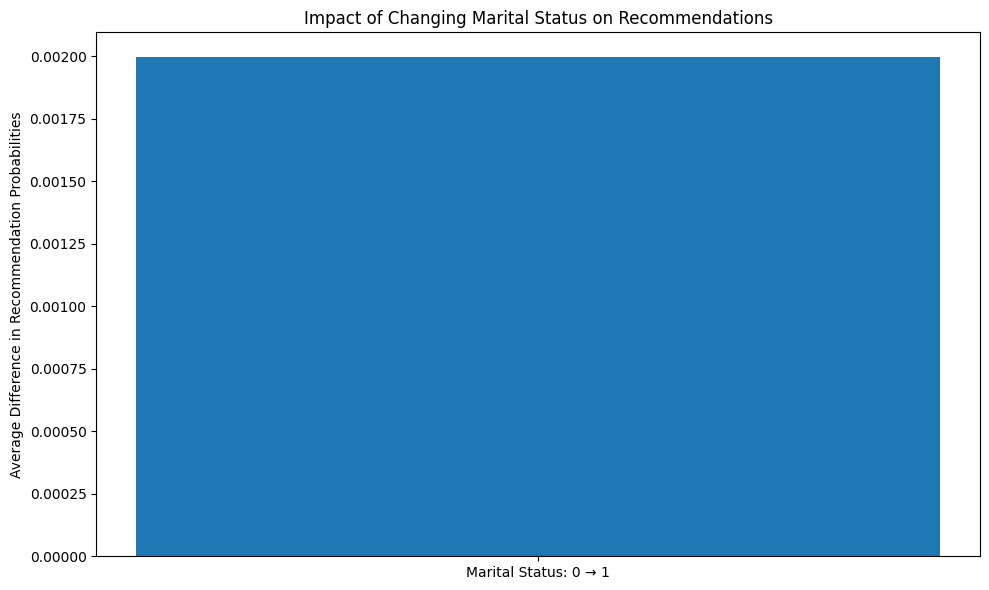


Top 5 recommendations most affected by changing Marital Status from 0 to 1:
- "Automate savings for retirement" (increased by 0.0097)
- "Start investing in retirement plans" (increased by 0.0097)
- "Allocate 1-3 hours a week into improving your career-related skills" (increased by 0.0087)
- "Consider getting a gym membership" (decreased by 0.0077)
- "Join group art classes" (increased by 0.0062)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 267ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step


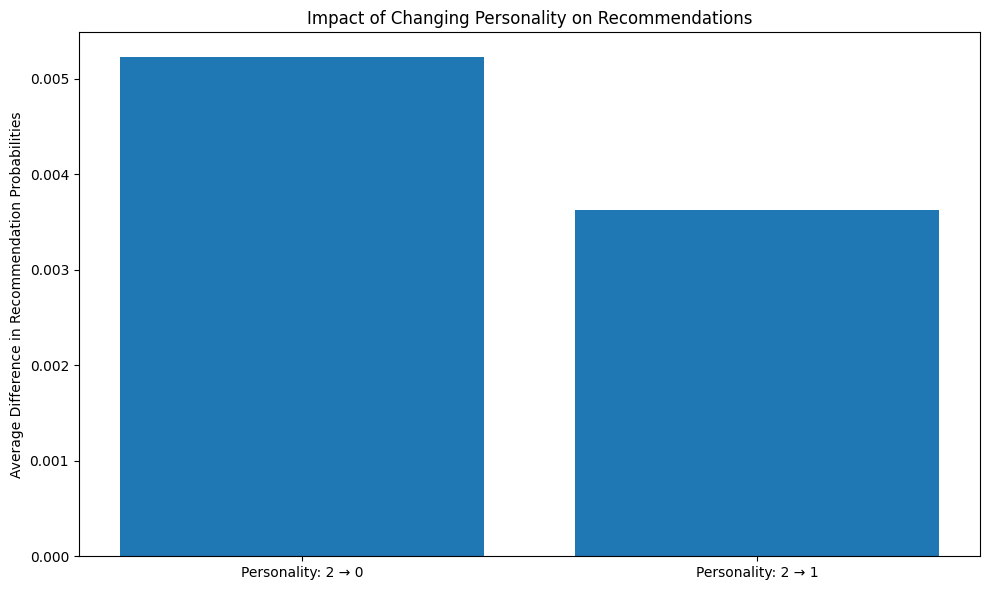


Top 5 recommendations most affected by changing Personality from 2 to 0:
- "Attend social events or meetups" (increased by 0.0785)
- "Track monthly expenses" (increased by 0.0130)
- "Build financial awareness" (increased by 0.0130)
- "Consider getting a gym membership" (decreased by 0.0121)
- "Participate in group adventure activities or social game nights" (increased by 0.0100)

Top 5 recommendations most affected by changing Personality from 2 to 1:
- "Join group art classes" (increased by 0.0426)
- "Visit art fairs with friends" (increased by 0.0426)
- "Track monthly expenses" (increased by 0.0135)
- "Build financial awareness" (increased by 0.0135)
- "Explore an art workshop" (increased by 0.0060)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step


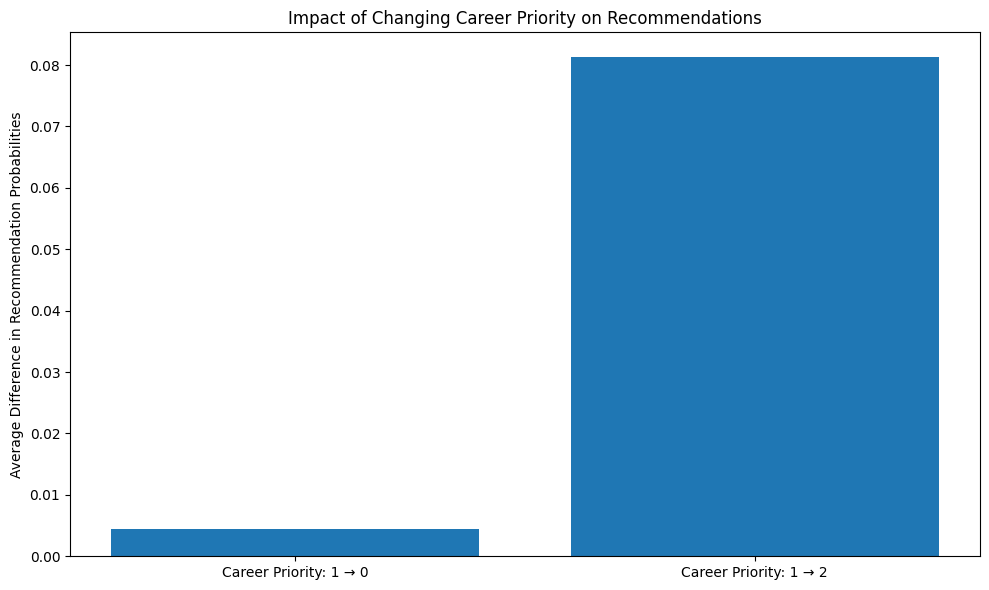


Top 5 recommendations most affected by changing Career Priority from 1 to 0:
- "Track monthly expenses" (increased by 0.0483)
- "Build financial awareness" (increased by 0.0483)
- "Attend social events or meetups" (increased by 0.0123)
- "Automate savings for retirement" (increased by 0.0115)
- "Start investing in retirement plans" (increased by 0.0115)

Top 5 recommendations most affected by changing Career Priority from 1 to 2:
- "Allocate 1-3 hours a week into improving your career-related skills" (increased by 0.9785)
- "Regularly update your resume" (increased by 0.9669)
- "Explore online professional networking platforms" (increased by 0.6972)
- "Track monthly expenses" (decreased by 0.0939)
- "Build financial awareness" (decreased by 0.0939)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step


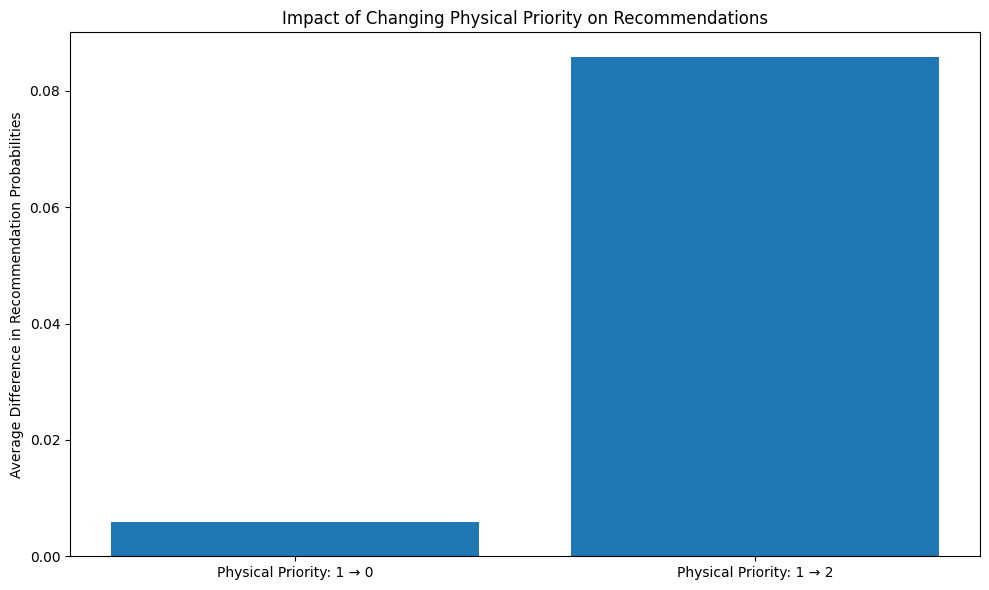


Top 5 recommendations most affected by changing Physical Priority from 1 to 0:
- "Join group art classes" (increased by 0.0431)
- "Visit art fairs with friends" (increased by 0.0431)
- "Track monthly expenses" (increased by 0.0310)
- "Build financial awareness" (increased by 0.0310)
- "Consider getting a gym membership" (decreased by 0.0213)

Top 5 recommendations most affected by changing Physical Priority from 1 to 2:
- "Attend regular preventative medical checkups" (increased by 1.0000)
- "Eat healthy foods" (increased by 1.0000)
- "Consider getting a gym membership" (increased by 0.8909)
- "Track monthly expenses" (decreased by 0.0930)
- "Build financial awareness" (decreased by 0.0930)


In [15]:
def get_recommendations_vector(user_features, model_path="harmony_deep_model.h5"):
    """Get raw recommendation probabilities for sensitivity analysis."""
    model = tf.keras.models.load_model(model_path)

    with open("harmony_deep_model_scaler.pkl", "rb") as f:
        scaler = pickle.load(f)

    user_features = np.array(user_features).reshape(1, -1)
    user_features[:, [0, 3]] = scaler.transform(user_features[:, [0, 3]])

    return model.predict(user_features)[0]

def compare_feature_impact(base_features, feature_index, values_to_try, feature_name):
    """Compare how changing a single feature impacts recommendations."""
    # Get recommendation vectors for each value
    recommendation_vectors = []
    for value in values_to_try:
        test_features = base_features.copy()
        test_features[feature_index] = value
        rec_vector = get_recommendations_vector(test_features)
        recommendation_vectors.append(rec_vector)

    # Load unique recommendations
    with open("harmony_deep_model_recommendations.pkl", "rb") as f:
        unique_recommendations = pickle.load(f)

    # Calculate average difference
    avg_diffs = []
    for i in range(1, len(recommendation_vectors)):
        avg_diff = np.abs(recommendation_vectors[i] - recommendation_vectors[0]).mean()
        avg_diffs.append(avg_diff)

    # Plot the differences
    plt.figure(figsize=(10, 6))
    plt.bar(range(len(avg_diffs)), avg_diffs)
    plt.xticks(range(len(avg_diffs)), [f"{feature_name}: {values_to_try[0]} → {values_to_try[i+1]}" for i in range(len(avg_diffs))])
    plt.title(f"Impact of Changing {feature_name} on Recommendations")
    plt.ylabel("Average Difference in Recommendation Probabilities")
    plt.tight_layout()
    plt.show()

    # Find top 5 recommendations most affected
    for i in range(len(avg_diffs)):
        diff_vector = np.abs(recommendation_vectors[i+1] - recommendation_vectors[0])
        top_indices = np.argsort(diff_vector)[-5:]

        print(f"\nTop 5 recommendations most affected by changing {feature_name} from {values_to_try[0]} to {values_to_try[i+1]}:")
        for idx in reversed(top_indices):
            change = recommendation_vectors[i+1][idx] - recommendation_vectors[0][idx]
            direction = "increased" if change > 0 else "decreased"
            print(f"- \"{unique_recommendations[idx]}\" ({direction} by {abs(change):.4f})")

# Base user profile for sensitivity analysis
base_user = [
    35,    # Age
    0,     # Marital Status: Single
    0,     # Occupation: Full-time
    3000,  # Budget
    2,     # Personality: Ambivert
    3,     # Hobby: Art
    1,     # Career Priority: Medium
    1,     # Financial Priority: Medium
    1,     # Spiritual Priority: Medium
    1,     # Physical Priority: Medium
    1,     # Intellectual Priority: Medium
    1,     # Family Priority: Medium
    1,     # Social Priority: Medium
    1      # Fun Priority: Medium
]

# Analyze impact of changing marital status
compare_feature_impact(base_user, 1, [0, 1], "Marital Status")

# Analyze impact of changing personality
compare_feature_impact(base_user, 4, [2, 0, 1], "Personality")

# Analyze impact of changing career priority
compare_feature_impact(base_user, 6, [1, 0, 2], "Career Priority")

# Analyze impact of changing physical priority
compare_feature_impact(base_user, 9, [1, 0, 2], "Physical Priority")

## 8. Limitations and Future Improvements

### Key limitations of our current approach include:

1. **Simulated Data**: The model is trained on synthetic data, which may not accurately reflect real-world patterns and preferences.

2. **Limited Feature Set**: The current model uses a relatively small set of features to predict recommendations.

3. **No User Feedback**: The model doesn't incorporate user feedback on recommendations.

4. **Fixed Recommendation Set**: The model can only recommend activities it was trained on.

### Future improvements could include:

1. **Hybrid Recommender System**: Combine deep learning with collaborative filtering for more personalized recommendations.

2. **Integrate User Feedback**: Implement a feedback mechanism to improve recommendations over time.

3. **Contextual Features**: Add contextual information like location, season, or current life events.

4. **More Sophisticated Model Architecture**: Explore attention mechanisms or transformer-based models.

5. **Dynamic Recommendation Generation**: Instead of fixed recommendations, generate contextual and personalized advice.

6. **User Studies**: Conduct user studies to evaluate effectiveness of recommendations in real-world scenarios.


## 9. Conclusion

### In this notebook, we successfully:

1. Prepared and explored our synthetic dataset for the LifeHarmony recommender system
2. Built and trained a deep learning model for multi-label recommendation
3. Evaluated the model's performance across different metrics
4. Tested the model with diverse user profiles
5. Conducted sensitivity analysis to understand how different features impact recommendations

--> The model shows promising performance in generating personalized life balance recommendations based on user attributes and domain priorities. However, as noted in the limitations section, there are several opportunities for future improvements.

### Next steps would be to:
1. Integrate this model into a user-friendly application
2. Implement mechanisms for collecting user feedback
3. Refine the model based on real user data
